This notebook is to make the final version of Figure 2, which has the MDS plot and the between patient same-site beta diversities.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

# to pretty print dataframes
from IPython.display import display

plt.style.use('seaborn-white')

In [2]:
# Raw data
fnotu = '/Users/claire/github/aspiration-analysis/data/clean/rosen.otu_table.rel_abun.clean'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

df = pd.read_csv(fnotu, sep='\t', index_col=0)
meta = pd.read_csv(fnmeta, sep='\t', index_col=0)

# JSD
fnjsd = '/Users/claire/github/aspiration-analysis/data/analysis/jsd.wide.txt'
jsd = pd.read_csv(fnjsd, sep='\t', index_col=0)

# Seed random state
random_state = 212345

In [3]:
#sns.palplot(sns.color_palette("Set1"))

In [4]:
# Prepare colors
pal = sns.color_palette("Set1")

sites = ['bal', 'throat_swab', 'gastric_fluid', 'stool']
colors = [pal[1], pal[2], pal[0], pal[4]]
colordict = {i: k for i, k in zip(sites, colors)}


## PCoA for 2014 and 2016 batches

We'll make the PCoA plots for each batch separately (otherwise, you can see the different batches).

### 2016 batch

The 2016 batch has the stool samples, so this will be the one in the paper. Let's plot this one first:

In [5]:
# Get samples from the 4 sites of interest and in 2016 batch
keep_batch = meta\
    .query('site == @sites')\
    .query('batch == 2016')\
    .index

# Get rid of any "F" samples (these are second time points samples)
# There is also one patient with duplicate throat and stool samples taht end in 'sick'
keep_batch = [i for i in keep_batch 
              if not i.endswith('F') 
              and not i.endswith('sick') 
              and not i.endswith('F2') 
              and not i.endswith('F2T')
              and not i.startswith('05')]

In [6]:
# Make sure all patients only have one sample per site represented here
tmp = meta.loc[keep_batch].groupby(['subject_id', 'site']).size()
tmp[tmp > 1]

Series([], dtype: int64)

('bal', 21)
('throat_swab', 52)
('gastric_fluid', 43)
('stool', 14)


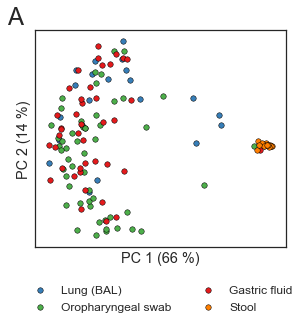

In [7]:
# Prepare for plotting
sns.set_style('white')
labels = {'gastric_fluid': 'Gastric fluid',
          'throat_swab': 'Oropharyngeal swab',
          'bal': 'Lung (BAL)',
          'stool': 'Stool'}

## Do PCA
pca2016 = PCA(random_state=random_state)\
    .fit(jsd.loc[keep_batch, keep_batch].values)

Y2016 = pca2016.transform(jsd.loc[keep_batch, keep_batch].values)

# Put PC's in a df and add metadata
df2016 = pd.DataFrame(Y2016, index=keep_batch, columns=range(0, Y2016.shape[1]))
df2016 = df2016.join(meta[['site', 'batch']])

## Plot

# Set up figure
fig, ax = plt.subplots(figsize=(4.5,4))

# Plot each site
for site in sites:
    subdf = df2016.query('site == @site')
    print(site, subdf.shape[0])
    ax.scatter(subdf.iloc[:, 0], subdf.iloc[:, 1], 
                c=colordict[site], 
                label=labels[site],
                s=30, linewidths=0.5, edgecolor='k')

## Figure annotations/labels
# Legend
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
                ncol=2, fontsize='large')

# X and Y labels
ax.set_xlabel(
    'PC 1 ({:.0f} %)'.format(pca2016.explained_variance_ratio_[0]*100),
    fontsize='x-large')
ax.set_ylabel(
    'PC 2 ({:.0f} %)'.format(pca2016.explained_variance_ratio_[1]*100),
    fontsize='x-large')

# Get rid of x and y ticks (I think this is ok, right?)
ax.set_xticks([])
ax.set_yticks([])

#plt.title('PCoA', fontsize='x-large')
txt = ax.text(-0.11, 1.025, 'A', transform=ax.transAxes, fontsize=24)

fig.savefig('../../final/figures/figure2.pcoa.png', 
            bbox_extra_artists=(lgd, txt), bbox_inches='tight',
            dpi=200)
fig.savefig('../../final/figures/figure2.pcoa.pdf', 
            bbox_extra_artists=(lgd, txt), bbox_inches='tight',
            dpi=500)

### Patients in 2016 PCoA

In [8]:
samples = keep_batch
meta\
    .loc[samples, ['subject_id', 'mbs_consolidated', 'site']]\
    .drop_duplicates()\
    .fillna('nan')\
    .groupby(['site', 'mbs_consolidated'])\
    .size()

site           mbs_consolidated      
bal            Aspiration/Penetration    13
               Normal                     6
               nan                        2
gastric_fluid  Aspiration/Penetration    18
               Normal                    11
               nan                       14
stool          nan                       14
throat_swab    Aspiration/Penetration    17
               Normal                     7
               nan                       28
dtype: int64

In [9]:
meta\
    .loc[samples, ['subject_id', 'mbs_consolidated', 'site']]\
    .drop_duplicates()\
    .fillna('nan')\
    .groupby(['site'])\
    .size()

site
bal              21
gastric_fluid    43
stool            14
throat_swab      52
dtype: int64

### Write patients to file

In [10]:
with open('../../data/patients/figure2.2016_pcoa.samples.txt', 'w') as f:
    f.write('\n'.join(samples))

## 2014 samples, PCA

('bal', 81)
('throat_swab', 124)
('gastric_fluid', 104)
('stool', 11)


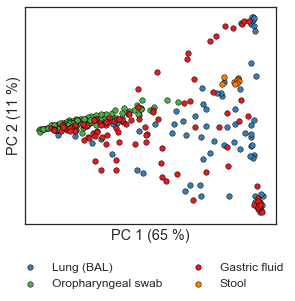

In [11]:
#from sklearn.manifold import MDS

## PCA on the 2014 samples
# Get samples from the 4 sites of interest and in 2016 batch
keep_batch = meta\
    .query('site == @sites')\
    .query('batch == 2014')\
    .index

# Get rid of any "F" samples (these are second time points samples)
# There is also one patient with duplicate throat and stool samples taht end in 'sick'
keep_batch = [i for i in keep_batch 
              if not i.endswith('F') 
              and not i.endswith('sick') 
              and not i.endswith('F2') 
              and not i.endswith('F2T')
              and not i.startswith('05')]

## Do PCA
pca2014 = PCA(random_state=random_state)\
    .fit(jsd.loc[keep_batch, keep_batch].values)

Y2014 = pca2014.transform(jsd.loc[keep_batch, keep_batch].values)
#Y2014 = MDS().fit_transform(jsd.loc[keep_batch, keep_batch].values)

# Put PC's in a df and add metadata
df2014 = pd.DataFrame(Y2014, index=keep_batch, columns=range(0, Y2014.shape[1]))
df2014 = df2014.join(meta[['site', 'batch']])

## Plot

# Set up figure
fig, ax = plt.subplots(figsize=(4.5,4))

# Plot each site
for site in sites:
    subdf = df2014.query('site == @site')
    print(site, subdf.shape[0])
    ax.scatter(subdf.iloc[:, 0], subdf.iloc[:, 1], 
                c=colordict[site], 
                label=labels[site],
                s=30, linewidths=0.5, edgecolor='k')
## Figure annotations/labels
# Legend
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
                ncol=2, fontsize='large')

# X and Y labels
ax.set_xlabel(
    'PC 1 ({:.0f} %)'.format(pca2014.explained_variance_ratio_[0]*100),
    fontsize='x-large')
ax.set_ylabel(
    'PC 2 ({:.0f} %)'.format(pca2014.explained_variance_ratio_[1]*100),
    fontsize='x-large')

# Get rid of x and y ticks (I think this is ok, right?)
ax.set_xticks([])
ax.set_yticks([])

#plt.title('PCoA', fontsize='x-large')
#txt = ax.text(-0.11, 1.025, 'B', transform=ax.transAxes, fontsize=24)

fig.savefig('../../final/figures/suppfig.pcoa_2014_batch.png', 
            bbox_extra_artists=(lgd, txt), bbox_inches='tight',
            dpi=200)

### Patients in this figure

In [12]:
samples = keep_batch
meta\
    .loc[samples, ['subject_id', 'mbs_consolidated', 'site']]\
    .drop_duplicates()\
    .fillna('nan')\
    .groupby(['site', 'mbs_consolidated'])\
    .size()

site           mbs_consolidated      
bal            Aspiration/Penetration    20
               Normal                    27
               nan                       34
gastric_fluid  Aspiration/Penetration    23
               Normal                    37
               nan                       44
stool          nan                       11
throat_swab    Aspiration/Penetration    19
               Normal                    36
               nan                       69
dtype: int64

In [13]:
meta\
    .loc[samples, ['subject_id', 'mbs_consolidated', 'site']]\
    .drop_duplicates()\
    .fillna('nan')\
    .groupby(['site'])\
    .size()

site
bal               81
gastric_fluid    104
stool             11
throat_swab      124
dtype: int64

### Write patients to file

In [14]:
with open('../../data/patients/figure2.2014_pcoa.samples.txt', 'w') as f:
    f.write('\n'.join(samples))

# Across-patient beta diversity

Now, let's make the other part of this figure: the across-patient beta diversity (between same sites across different patients.)

Here, we'll plot results from both batches together, while ensuring that we only keep within-batch comparisons.

In [8]:
# For these plots, I'll need to select just the within-sequencing batch comparisons
# in addition to making sure there are no duplicate samples from the same patient

In [9]:
fnjsdlong = '../../data/analysis/jsd.txt'
jsdlong = pd.read_csv(fnjsdlong, sep='\t')
jsdlong.head()

/Users/claire/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sample1,sample2,beta,site1,site2,site_comparison,patient_comp,subject,batch1,batch2,...,percent distal acid,percent proximal acid,percent proximal nonacid,percent distal total,number of full colum events/total events,Number of full column episodes,Was Bile CA detected?,Was Bile DCA detected?,Was Bile LCA detected?,Was Bile TCA detected?
0,01-112-7GI,01-112-7RI,0.400324,gastric_fluid,rectal_swab,gastric_fluid-rectal_swab,within,01-112-7,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01-112-7GI,01-112-7TI,0.993353,gastric_fluid,throat_swab,gastric_fluid-throat_swab,within,01-112-7,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01-112-7GI,01-164-7GI,0.994055,gastric_fluid,gastric_fluid,gastric_fluid-gastric_fluid,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01-112-7GI,01-164-7RI,0.575080,gastric_fluid,rectal_swab,gastric_fluid-rectal_swab,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01-112-7GI,01-164-7TI,0.995439,gastric_fluid,throat_swab,gastric_fluid-throat_swab,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Remove "final" throat and stool samples
print(jsdlong.shape[0])
jsdlong = jsdlong[~jsdlong['sample1'].str.endswith('F')]
print(jsdlong.shape[0])
jsdlong = jsdlong[~jsdlong['sample2'].str.endswith('F')]
print(jsdlong.shape[0])
jsdlong = jsdlong[~jsdlong['sample1'].str.endswith('sick')]
print(jsdlong.shape[0])
jsdlong = jsdlong[~jsdlong['sample2'].str.endswith('sick')]
print(jsdlong.shape[0])
jsdlong = jsdlong[~jsdlong['sample1'].str.endswith('F2')]
jsdlong = jsdlong[~jsdlong['sample2'].str.endswith('F2')]
jsdlong = jsdlong[~jsdlong['sample1'].str.endswith('F2T')]
jsdlong = jsdlong[~jsdlong['sample2'].str.endswith('F2T')]
# Remove lung transplant samples
jsdlong = jsdlong[~jsdlong['sample1'].str.startswith('05')]
jsdlong = jsdlong[~jsdlong['sample2'].str.startswith('05')]
print(jsdlong.shape[0])

103285
103285
103285
103285
103285
103285


Note: I've moved this check into the actual JSD calculation script. I'll leave this here though, just for future sanity check. The code that does this is in `src/analysis/jsd.py`:

```
# Don't include samples from second time point or lung transplants
exclude = ['2', 'F', 'sick', 'F2T']
for s in exclude:
    samples = [i for i in samples if not i.endswith(s)]
samples = [i for i in samples if not i.startswith('05')]
```

In [11]:
# Keep just the "between" patient comparisons
btw_jsd = jsdlong.query('patient_comp == "between"')

# Keep just aerodigestive site comparisons
keep_comps = ['bal-bal', 'throat_swab-throat_swab', 'gastric_fluid-gastric_fluid']
btw_jsd = btw_jsd.query('site_comparison == @keep_comps')

btw_jsd.fillna('nan').groupby(['site_comparison', 'batch1', 'batch2']).size()

site_comparison              batch1  batch2
bal-bal                      2014    2014      3160
                                     2016      1364
                             2016    2014       316
                                     2016       210
gastric_fluid-gastric_fluid  2014    2014      5151
                                     2016      2827
                             2016    2014      1559
                                     2016       903
throat_swab-throat_swab      2014    2014      7503
                                     2016      3642
                             2016    2014      2754
                                     2016      1326
dtype: int64

In [12]:
jsd2014 = btw_jsd.query('(batch1 == 2014) & (batch2 == 2014)')
jsd2016 = btw_jsd.query('(batch1 == 2016) & (batch2 == 2016)')

jsdboth = pd.concat((jsd2014, jsd2016))

/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


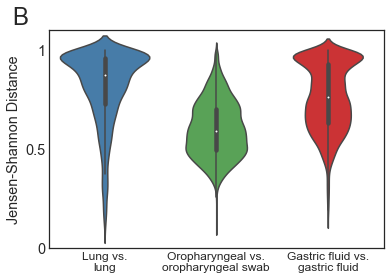

In [13]:
order_fig = ['bal-bal', 'throat_swab-throat_swab', 'gastric_fluid-gastric_fluid']

# Prepare colors
pal = sns.color_palette("Set1")
colors = [pal[1], pal[2], pal[0]]
colordict = {i: k for i, k in zip(order_fig, colors)}

fig, ax = plt.subplots()
sns.violinplot(data=jsdboth, x='site_comparison', y='beta', 
               inner='box', order=order_fig,
               palette=colordict)


ax.set_xlabel('')
ax.set_xticklabels(['Lung vs.\nlung', 
                    'Oropharyngeal vs.\noropharyngeal swab',
                    'Gastric fluid vs.\ngastric fluid'],
                  fontsize='large')
ax.set_ylim([0, 1.1])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1], fontsize='x-large')
ax.set_ylabel('Jensen-Shannon Distance', fontsize='x-large')

ax.text(-0.11, 1.025, 'B', transform=ax.transAxes, fontsize=24)

#ax.set_title('Across patient beta diversity', fontsize='xx-large')
fig.savefig('../../final/figures/figure2.across_patient_beta_div_same_site.png', dpi=200)
fig.savefig('../../final/figures/figure2.across_patient_beta_div_same_site.pdf', dpi=500)

## Sample size

Next, we'll print out some information about the number of samples in each comparison and the mean, std, median, etc JSD for each comparison type:

In [21]:
jsdboth.groupby('site_comparison')['beta'].describe()

,count,mean,std,min,25%,50%,75%,max
site_comparison,,,,,,,,
bal-bal,3450.0,0.816503,0.187786,0.098206,0.731513,0.877055,0.964893,0.999219
gastric_fluid-gastric_fluid,6259.0,0.764649,0.169653,0.159927,0.633807,0.763999,0.928130,0.998176
throat_swab-throat_swab,8952.0,0.599972,0.139513,0.110568,0.491617,0.588559,0.701691,0.992263


## Samples

We'll also write the samples used in this figure to a file, for future reference.

In [22]:
allsamples = jsdboth['sample1'].tolist() + jsdboth['sample2'].tolist()
print('{} total comparisons from {} unique patients'.format(len(allsamples), len(set(allsamples))))

37322 total comparisons from 425 unique patients


In [23]:
with open('../../data/patients/figure2.between_patient_jsd.samples.txt', 'w') as f:
    f.write('\n'.join(set(allsamples)))

# PERMANOVA and ANOSIM

Calculate PERMANOVA statistics within each sequencing batch.

In [24]:
from skbio.stats.distance import permanova, anosim
from skbio.stats.distance import DistanceMatrix

In [25]:
sites = ['bal', 'throat_swab', 'gastric_fluid']

## 2016 samples

In [26]:
# Get samples from the 4 sites of interest and in 2016 batch
keep_batch = meta\
    .query('site == @sites')\
    .query('batch == 2016')\
    .index

# Get rid of any "F" samples (these are second time points samples)
# There is also one patient with duplicate throat and stool samples taht end in 'sick'
keep_batch = [i for i in keep_batch 
              if not i.endswith('F') 
              and not i.endswith('sick') 
              and not i.endswith('F2') 
              and not i.endswith('F2T')
              and not i.startswith('05')]

# Check that no patient has duplicate sites
tmp = meta.loc[keep_batch].groupby(['subject_id', 'site']).size()
print(tmp[tmp > 1])

jsd2016 = jsd.loc[keep_batch, keep_batch]


Series([], dtype: int64)


In [27]:
dm = DistanceMatrix(jsd2016.values, ids=jsd2016.index)
permanova(dm, meta.loc[jsd2016.index, 'site'], permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     116
number of groups                  3
test statistic              3.23894
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [28]:
anosim(dm, meta.loc[jsd2016.index, 'site'], permutations=9999)

method name                 ANOSIM
test statistic name              R
sample size                    116
number of groups                 3
test statistic            0.112103
p-value                     0.0002
number of permutations        9999
Name: ANOSIM results, dtype: object

Just for thoroughness, also write these patients to a _separate_ file.

In [29]:
with open('../../data/patients/figure2.between_patient_jsd_2016_permanova.samples.txt', 'w') as f:
    f.write('\n'.join(keep_batch))

## 2014 samples

In [30]:
# Get samples from the 4 sites of interest and in 2016 batch
keep_batch = meta\
    .query('site == @sites')\
    .query('batch == 2014')\
    .index

# Get rid of any "F" samples (these are second time points samples)
# There is also one patient with duplicate throat and stool samples taht end in 'sick'
keep_batch = [i for i in keep_batch 
              if not i.endswith('F') 
              and not i.endswith('sick') 
              and not i.endswith('F2') 
              and not i.endswith('F2T')
              and not i.startswith('05')]

# Check that no patient has duplicate sites
tmp = meta.loc[keep_batch].groupby(['subject_id', 'site']).size()
print(tmp[tmp > 1])

jsd2014 = jsd.loc[keep_batch, keep_batch]

Series([], dtype: int64)


In [31]:
dm = DistanceMatrix(jsd2014.values, ids=jsd2014.index)
permanova(dm, meta.loc[jsd2014.index, 'site'], permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     309
number of groups                  3
test statistic              27.4298
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [32]:
anosim(dm, meta.loc[jsd2014.index, 'site'], permutations=9999)

method name                 ANOSIM
test statistic name              R
sample size                    309
number of groups                 3
test statistic            0.385123
p-value                     0.0001
number of permutations        9999
Name: ANOSIM results, dtype: object

Also write down the samples I used in these analyses.

In [33]:
with open('../../data/patients/figure2.between_patient_jsd_2014_permanova.samples.txt', 'w') as f:
    f.write('\n'.join(keep_batch))

# Total patients in these analyses

Here are the numbers of aspirators/non-aspirators present overall in this across-patient comparison. I won't write these to a file because it'll be cleaner to back this out from the individual sample files I wrote for each part of this analysis.

In [34]:
samples = jsd2014.index.tolist() + jsd2016.index.tolist()
len(samples)

425

In [35]:
meta\
    .loc[samples, ['subject_id', 'mbs_consolidated', 'site']]\
    .drop_duplicates()\
    .fillna('nan')\
    .groupby(['site', 'mbs_consolidated'])\
    .size()

site           mbs_consolidated      
bal            Aspiration/Penetration    33
               Normal                    33
               nan                       36
gastric_fluid  Aspiration/Penetration    41
               Normal                    48
               nan                       58
throat_swab    Aspiration/Penetration    36
               Normal                    43
               nan                       97
dtype: int64